In [1]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor 
import matplotlib.pyplot as plt
import os.path
from os import path
from sklearn.neural_network import MLPRegressor

In [2]:
def LoadRawVariables():
    c2pt = []
    ts   = []
    taus = []
    xs   = []
    ys   = []
    zs   = []
    c3pt_S = []
    c3pt_V = []
    c3pt_A = []
    c2pt_OTHER = []
    
    
    for tau in range(0, 49, 8):
        for x in range(0, 25, 8):
            for y in range(0, 25, 8):
                for z in range(0, 25, 8):
                    for sample in range(748, 1421, 16):
                        fname = "../Data/T" + str(tau) + "/x" + str(x) + "y" + str(y) + "z" + str(z) + "/nuc3pt.dat." + str(sample)
                        if path.exists(fname):
                            with open(fname) as fp:
                                for i, line in enumerate(fp):
                                    if i >= 7 and i <= 70:           # The start of Gauss -> Point 2pt correlation functions
                                        c2pt_OTHER.append([float(x) for x in line.rstrip().split()[1:3]])
                                    if i >= 5182 and i <= 5245:      # The start of Gauss -> Gauss 2pt correlation functions
                                        c2pt.append([float(x) for x in line.rstrip().split()[1:3]])
                                        ts.append(i - 5182)
                                        taus.append(tau)
                                        xs.append(x)
                                        ys.append(y)
                                        zs.append(z)
                                    elif i >= 10154 and i <= 10217:
                                        c3pt_S.append([float(x) for x in line.rstrip().split()[1:3]])
                                    elif i >= 10229 and i <= 10292:
                                        c3pt_V.append([float(x) for x in line.rstrip().split()[1:3]])
                                    elif i >= 19979 and i <= 20042:
                                        c3pt_A.append([float(x) for x in line.rstrip().split()[1:3]])
                                    elif i > 20042:
                                        break
    
    return ts, taus, xs, ys, zs, c2pt, c3pt_S, c3pt_V, c3pt_A, c2pt_OTHER

ts, taus, xs, ys, zs, c2pt, c3pt_S, c3pt_V, c3pt_A, c2pt_OTHER = LoadRawVariables()

c2pt_factor_raw = sum(np.array(c2pt)) / len(c2pt)
N_factor = np.sqrt(c2pt_factor_raw[0] ** 2 + c2pt_factor_raw[1] ** 2)

for i in range(len(c2pt)):
    for j in range(2):
        c2pt[i][j] /= N_factor
        c3pt_S[i][j] /= N_factor
        c3pt_V[i][j] /= N_factor
        c3pt_A[i][j] /= N_factor
        c2pt_OTHER[i][j] /= N_factor

## Prediction of c3pt conglomerate based on c2pt snapshot

In [3]:
# features = np.array([np.array([ts[i], taus[i], xs[i], ys[i], zs[i], c2pt[i][0], c2pt[i][1]]) for i in range(len(ts))])
features_unshifted = np.array([[taus[i]] + [c2pt[i + j][0] for j in range(64)] + [c2pt[i + j][1] for j in range(64)] for i in range(0, len(ts), 64)])
features = []
for f in features_unshifted:
    shift = int(f[0])
    features.append(np.roll(f[1:], -shift))
#### THIS IS WORSE ---> Try sparsely sampling features to combat large amount of data 
# for i in range(len(features)):
#     sparseSubFeature = np.array([features[i][j] for j in range(0, len(features[i]), 8)])
#     features[i] = sparseSubFeature

features = np.array(features)

labels_S = np.array([sum(c3pt_S[i:i+64][0]) / 64 for i in range(0, len(c3pt_S), 64)])
labels_A = np.array([sum(c3pt_A[i:i+64][0]) / 64 for i in range(0, len(c3pt_A), 64)])
labels_V = np.array([sum(c3pt_V[i:i+64][0]) / 64 for i in range(0, len(c3pt_V), 64)])


## Prediction of scalar charge

In [18]:
labelFrac = 0.5
BCFrac = 0.1

labelEnd = int(len(labels_S) * labelFrac)
BCEnd    = int(len(labels_S) * (BCFrac + labelFrac))

X_train, Y_train, X_bc, Y_bc, X_test, Y_test = features[:labelEnd], labels_S[:labelEnd], features[labelEnd:BCEnd], labels_S[labelEnd:BCEnd], features[BCEnd:], labels_S[BCEnd:]

# gbr = GradientBoostingRegressor(learning_rate=0.05, n_estimators=50, max_depth=3)
gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
gbr.fit(X_train, Y_train)

y_bc_pred = gbr.predict(X_bc)

biasCrxn = np.average(Y_bc - y_bc_pred)
print(biasCrxn)

-0.003426123221014777


Prediction quality: 0.3814055919907827


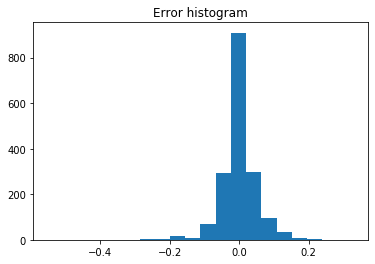

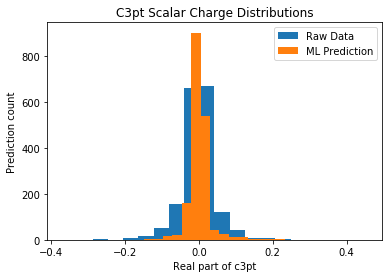

In [20]:
trials = 0
errors = []
raw_RMS = 0
ML_samples = []
DM_samples = []
for i in range(len(X_test)):
    testImg = X_test[i]
    testLabel = Y_test[i]
    pred = gbr.predict([testImg]) + biasCrxn
    errors.append(pred[0] - testLabel)
    ML_samples.append(pred[0])
    DM_samples.append(testLabel)
    
print("Prediction quality:", np.std(errors) / np.std(Y_train))
plt.title("Error histogram")
plt.hist(errors, bins=20)
plt.show()

plt.hist(DM_samples, bins=20)
plt.hist(ML_samples, bins=20)
plt.legend(["Raw Data", "ML Prediction"])
plt.xlabel("Real part of c3pt")
plt.ylabel("Prediction count")
plt.title("C3pt Scalar Charge Distributions")
plt.show()

## Prediction of Axial charge

In [13]:
labelFrac = 0.5
BCFrac = 0.1

labelEnd = int(len(labels_A) * labelFrac)
BCEnd    = int(len(labels_A) * (BCFrac + labelFrac))

X_train, Y_train, X_bc, Y_bc, X_test, Y_test = features[:labelEnd], labels_A[:labelEnd], features[labelEnd:BCEnd], labels_A[labelEnd:BCEnd], features[BCEnd:], labels_A[BCEnd:]

gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
gbr.fit(X_train, Y_train)

y_bc_pred = gbr.predict(X_bc)

biasCrxn = np.average(Y_bc - y_bc_pred)
print(biasCrxn)

-0.0003488723024609471


Prediction quality: 0.5433752473101404


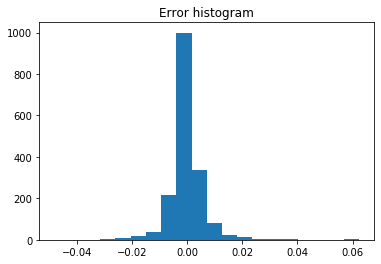

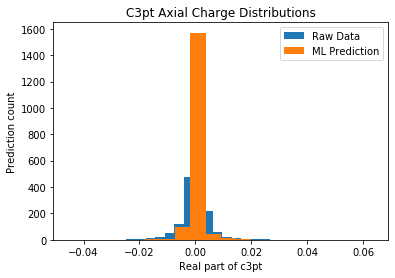

In [15]:
trials = 0
errors = []
raw_RMS = 0
ML_samples = []
DM_samples = []
for i in range(len(X_test)):
    testImg = X_test[i]
    testLabel = Y_test[i]
    pred = gbr.predict([testImg]) + biasCrxn
    errors.append(pred[0] - testLabel)
    ML_samples.append(pred[0])
    DM_samples.append(testLabel)
    
print("Prediction quality:", np.std(errors) / np.std(Y_train))
plt.title("Error histogram")
plt.hist(errors, bins=20)
plt.show()

plt.hist(DM_samples, bins=20)
plt.hist(ML_samples, bins=20)
plt.legend(["Raw Data", "ML Prediction"])
plt.xlabel("Real part of c3pt")
plt.ylabel("Prediction count")
plt.title("C3pt Axial Charge Distributions")
plt.show()

## Prediction of vector charge

In [16]:
labelFrac = 0.5
BCFrac = 0.1

labelEnd = int(len(labels_V) * labelFrac)
BCEnd    = int(len(labels_V) * (BCFrac + labelFrac))

X_train, Y_train, X_bc, Y_bc, X_test, Y_test = features[:labelEnd], labels_V[:labelEnd], features[labelEnd:BCEnd], labels_V[labelEnd:BCEnd], features[BCEnd:], labels_V[BCEnd:]

gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
gbr.fit(X_train, Y_train)

y_bc_pred = gbr.predict(X_bc)

biasCrxn = np.average(Y_bc - y_bc_pred)
print(biasCrxn)

0.000150589700001505


Prediction quality: 0.21604869796703768


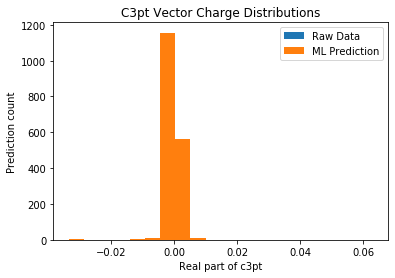

In [17]:
trials = 0
errors = []
raw_RMS = 0
ML_samples = []
DM_samples = []
for i in range(len(X_test)):
    testImg = X_test[i]
    testLabel = Y_test[i]
    pred = gbr.predict([testImg]) + biasCrxn
    errors.append(pred - testLabel)
    ML_samples.append(pred[0])
    DM_samples.append(testLabel)
    
print("Prediction quality:", np.std(errors) / np.std(Y_train))

plt.hist(DM_samples, bins=20)
plt.hist(ML_samples, bins=20)
plt.legend(["Raw Data", "ML Prediction"])
plt.xlabel("Real part of c3pt")
plt.ylabel("Prediction count")
plt.title("C3pt Vector Charge Distributions")
plt.show()

# Characterization based on parameters

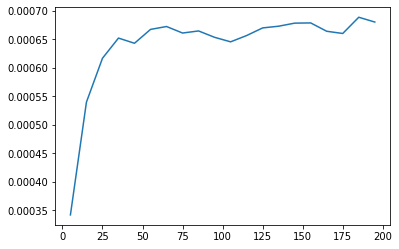

In [10]:
quals = []
for estims in range(5, 200, 10):
    gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=estims, max_depth=3)
    gbr.fit(X_train, Y_train)

    y_bc_pred = gbr.predict(X_bc)

    biasCrxn = np.average(Y_bc - y_bc_pred)

    trials = 0
    errors = []
    raw_RMS = 0
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel = Y_test[i]
        pred = gbr.predict([testImg]) + biasCrxn
        errors.append(pred - testLabel)
        ML_samples.append(pred[0])
        DM_samples.append(testLabel)

    quals.append(np.std(errors) / np.std(X_train))

plt.plot(list(range(5, 200, 10)), quals)
plt.show()

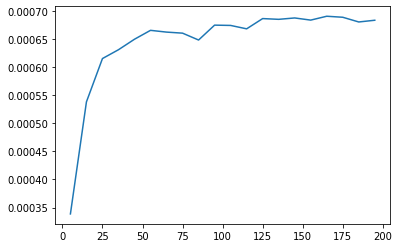

In [11]:
quals = []
for estims in range(5, 200, 10):
    gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=estims, max_depth=3)
    gbr.fit(X_train, Y_train)

    y_bc_pred = gbr.predict(X_bc)

    biasCrxn = np.average(Y_bc - y_bc_pred)

    trials = 0
    errors = []
    raw_RMS = 0
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel = Y_test[i]
        pred = gbr.predict([testImg]) + biasCrxn
        errors.append(pred - testLabel)
        ML_samples.append(pred[0])
        DM_samples.append(testLabel)

    quals.append(np.std(errors) / np.std(X_train))

plt.plot(list(range(5, 200, 10)), quals)
plt.show()

## Train based on a NN rather than a Decision Tree

In [12]:
# features = np.array([np.array([ts[i], taus[i], xs[i], ys[i], zs[i], c2pt[i][0], c2pt[i][1]]) for i in range(len(ts))])
features_unshifted = np.array([[taus[i]] + [c2pt[i + j][0] for j in range(64)] + [c2pt[i + j][1] for j in range(64)] for i in range(0, len(ts), 64)])
features = []
for f in features_unshifted:
    shift = int(f[0])
    features.append(np.roll(f[1:], -shift))
#### THIS IS WORSE ---> Try sparsely sampling features to combat large amount of data 
# for i in range(len(features)):
#     sparseSubFeature = np.array([features[i][j] for j in range(0, len(features[i]), 8)])
#     features[i] = sparseSubFeature

features = np.array(features)

labels = np.array([sum(c3pt[i:i+64][0]) / 64 for i in range(0, len(c3pt), 64)])

print(len(features), len(labels))
print(len(features[0]))

NameError: name 'c3pt' is not defined

In [ ]:
labelFrac = 0.9

labelEnd = int(len(labels) * labelFrac)

X_train, Y_train, X_test, Y_test = features[:labelEnd], labels[:labelEnd], features[labelEnd:], labels[labelEnd:]

mlp = MLPRegressor(max_iter=1000, learning_rate="adaptive", learning_rate_init=0.05)
mlp.fit(X_train, Y_train)

In [ ]:
trials = 0
errors = []
raw_RMS = 0
ML_samples = []
DM_samples = []
for i in range(len(X_test)):
    testImg = X_test[i]
    testLabel = Y_test[i]
    pred = mlp.predict([testImg]) + biasCrxn
    errors.append(pred - testLabel)
    ML_samples.append(pred[0])
    DM_samples.append(testLabel)
    
print("Prediction quality:", np.std(errors) / np.std(X_train))

plt.hist(DM_samples, bins=20)
plt.hist(ML_samples, bins=20)
plt.legend(["Raw Data", "ML Prediction"])
plt.xlabel("Real part of c3pt")
plt.ylabel("Prediction count")
plt.show()

## Prediction of c3pt based on c2pt directly